## Train and Benchmark and Neural Decoder  with Viterbi Decoder.

This notebook contains pipeline how to train a neural decoder model for decoding convolution code over BSC Channel at 1/2-RSC signal.



## Import required packages

In [1]:
import multiprocessing as mp
import time
import numpy as np
import commpy as cp
import tensorflow as tf

from deepcom.model import NRSCDecoder           # Neural Decoder Model
from deepcom.metrics import BER, BLER           # metrics to benchmark Neural Decoder Model
from deepcom.utils import corrupt_signal        # simulate a AWGN Channel

from deepcom.dataset import create_dataset      # Create synthetic dataset
from deepcom.dataset import data_genenerator    # data loader for Tensorflow

import  matplotlib.pyplot  as plt
%matplotlib inline

## Define Hyper-paramemeters for the experiment

In [2]:
# Number of training data
BLOCK_LEN = 100
NUM_TRAINING_DATA = 240000
NUM_TESTING_DATA  = 10000

# Communication Algo via Deep Learning (page 5, last paragraph)
NOISE_TYPE='bsc'
ERROR_PROB_TRAIN=0.15

# Network Architectures
NUM_LAYERS = 2
NUM_HIDDEN_UNITS = 400

# Hyper-parameters for training
BATCH_SIZE = 500       # depends on size of GPU, should be a factor of num_data
LEARNING_RATE = 1e-3
DROPOUT_RATE= 0.75


CONSTRAINT_LEN = 3     # num of shifts in Conv. Encoder
TRACE_BACK_DEPTH = 15  # (?) a parameter Viterbi Encoder

## Generate Synthetic Dataset for training/evaluation

In [3]:
from commpy.channelcoding import Trellis
#  Generator Matrix (octal representation)
G = np.array([[0o7, 0o5]]) 
M = np.array([CONSTRAINT_LEN - 1])
trellis = Trellis(M, G, feedback=0o7, code_type='rsc')

# Create dataset 
print('Creating training data....')

# X_train shape = [NUM_TRAINING_DATA, BLOCK_LENGTH, 2]
# Y_train shape = [NUM_TRAINING_DATA, BLOCK_LENGTH, 1]
X_train, Y_train = create_dataset(
    NUM_TRAINING_DATA, 
    BLOCK_LEN, 
    trellis, 
    noise_type=NOISE_TYPE, error_prob=ERROR_PROB_TRAIN, seed=2018)

print('Creating testing data....')
# X_test shape = [NUM_TESTING_DATA, BLOCK_LENGTH, 2]
# Y_test shape = [NUM_TESTING_DATA, BLOCK_LENGTH, 1]
X_test, Y_test = create_dataset(
    NUM_TESTING_DATA, 
    BLOCK_LEN, 
    trellis,
    noise_type=NOISE_TYPE, error_prob=ERROR_PROB_TRAIN, seed=1111)


print('Number of training sequences {}'.format(len(X_train)))
print('Number of testing sequences {}'.format(len(Y_test)))
# print(X_train.shape, Y_train.shape)

Creating training data....
Creating testing data....
Number of training sequences 240000
Number of testing sequences 10000


## Define Neural Decoder Model

In [4]:
# Construct Neural Decoder
inputs = tf.keras.Input(shape=(None, 2))
outputs = NRSCDecoder(
    inputs, 
    is_training=True, 
    num_layers=NUM_LAYERS, 
    hidden_units=NUM_HIDDEN_UNITS, 
    dropout=DROPOUT_RATE)
model = tf.keras.Model(inputs, outputs)

# Set up training 
model.compile('adam', 'binary_crossentropy', [BER, BLER])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 2)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 800)         967200    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 800)         3200      
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 800)         2882400   
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 800)         3200      
_________________________________________________________________
time_distributed (TimeDistri (None, None, 1)           801       
Total params: 3,856,801
Trainable params: 3,853,601
Non-trainable params: 3,200
______________________________________________________________

## Start Training/Eval Pipeline

In [6]:
# Set up Data Loader using tf.Dataset
train_set = data_genenerator(X_train, Y_train, BATCH_SIZE, shuffle=True)
test_set = data_genenerator(X_test, Y_test, BATCH_SIZE, shuffle=False)

# Backup best model
backup = tf.keras.callbacks.ModelCheckpoint(                     
  filepath='BiGRU.hdf5',
  monitor='val_loss',
  save_best_only=True)
    
# Stop training early if the model seems to overfit
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0,
    patience=3,
    verbose=0, mode='auto')

history = model.fit(
    train_set.make_one_shot_iterator(), 
    steps_per_epoch=len(X_train) //BATCH_SIZE, 
    validation_data=test_set.make_one_shot_iterator(),
    validation_steps= len(X_test) //BATCH_SIZE,
    callbacks=[early_stopping, backup],
    epochs=100)

model = tf.keras.models.load_model('BiGRU.hdf5',{'BER': BER, 'BLER': BLER})

Epoch 1/100
480/480 [==============================] - 638s 1s/step - loss: 0.4156 - BER: 0.1541 - BLER: 1.0000 - val_loss: 0.4218 - val_BER: 0.1496 - val_BLER: 1.0000
Epoch 2/100
480/480 [==============================] - 644s 1s/step - loss: 0.3633 - BER: 0.1398 - BLER: 1.0000 - val_loss: 0.3504 - val_BER: 0.1336 - val_BLER: 1.0000
Epoch 3/100
480/480 [==============================] - 637s 1s/step - loss: 0.3535 - BER: 0.1354 - BLER: 0.9999 - val_loss: 0.3444 - val_BER: 0.1328 - val_BLER: 0.9996
Epoch 4/100
480/480 [==============================] - 634s 1s/step - loss: 0.3488 - BER: 0.1344 - BLER: 0.9999 - val_loss: 0.3415 - val_BER: 0.1324 - val_BLER: 0.9996
Epoch 5/100
480/480 [==============================] - 632s 1s/step - loss: 0.3457 - BER: 0.1337 - BLER: 0.9998 - val_loss: 0.3391 - val_BER: 0.1317 - val_BLER: 0.9996
Epoch 6/100
480/480 [==============================] - 642s 1s/step - loss: 0.3435 - BER: 0.1333 - BLER: 0.9998 - val_loss: 0.3374 - val_BER: 0.1318 - val_BLER:

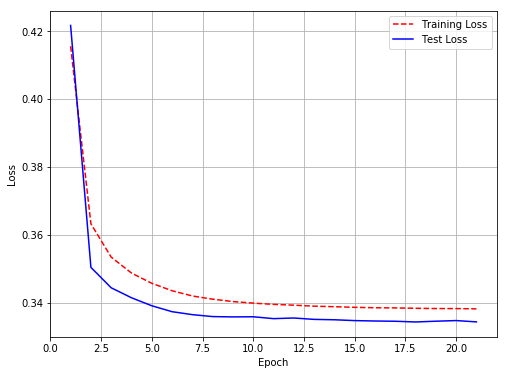

In [7]:
# Count of the number of epochs
epochs = range(1, len(history.history['loss']) + 1)
# Visualize loss history
plt.figure(figsize=(8, 6))
plt.plot(epochs, history.history['loss'], 'r--')
plt.plot(epochs, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

## Benchmark Neural Decoder

In [8]:
def benchmark_neural_decoder(noisy_inputs, labels):
    
    # Set up data generator
    Y = np.reshape(labels, (-1, BLOCK_LEN, 1))
    X = np.reshape(np.array(noisy_inputs)[:, :2*BLOCK_LEN], (-1, BLOCK_LEN, 2))
    test_set = data_genenerator(X, Y, BATCH_SIZE, shuffle=False)
    
    # Make predictions in batch
    decoded_bits = model.predict(
        test_set.make_one_shot_iterator(), 
        steps=len(Y) // BATCH_SIZE)
    
    # Compute hamming distances
    original_bits = np.reshape(Y, (-1, BLOCK_LEN)).astype(int)
    decoded_bits =  np.reshape(np.round(decoded_bits), (-1, BLOCK_LEN)).astype(int)
    hamming_dist = np.not_equal(original_bits, decoded_bits)
    
    return np.sum(hamming_dist, axis=1)

def benchmark_viterbi(message_bits, noisy_bits, sigma):
  
    # make fair comparison between (100, 204) convolutional code and RNN decoder
    # Reference: Author's code
    noisy_bits[-2*int(M):] = 0
    
    # Viterbi Decoder on Conv. Code
    decoded_bits = cp.channelcoding.viterbi_decode(
        coded_bits=noisy_bits.astype(float), 
        trellis=trellis,
        tb_depth=TRACE_BACK_DEPTH,
        decoding_type='hard')  # for BSC, 'unquantized' for AWGN
     
    # Number of bit errors (hamming distance)
    hamming_dist = cp.utilities.hamming_dist(
        message_bits.astype(int),
        decoded_bits[:-int(M)])
    return hamming_dist

 
# #################################################################
# For every SNR_db, we generates new noisy signals
# for fair comparision.
# #################################################################
def generate_noisy_input(message_bits, trellis, error_prob):
    # Encode message bit
    coded_bits = cp.channelcoding.conv_encode(message_bits, trellis)
    # Corrupt message on BSC Channel
    coded_bits = corrupt_signal(coded_bits, noise_type='bsc', error_prob=error_prob)
    return coded_bits, message_bits

In [9]:
viterbiBERs, viterbiBLERs = [], []
neuralBERs, neuralBLERs = [], []

pool = mp.Pool(processes=mp.cpu_count())
labels = np.reshape(Y_test, (-1, BLOCK_LEN)).astype(int)
try: 
    ERROR_PROBS  = np.linspace(0.01, 0.3, 8)
    for error_prob in ERROR_PROBS:
        print('[Prob]={:.2f}'.format(error_prob))
        
        # Generates new noisy signals
        result = pool.starmap(
            func=generate_noisy_input,  
            iterable=[(msg_bits, trellis, error_prob) for msg_bits in labels])
        
        X, Y =  zip(*result)
        
        # #################################################################
        # BENCHMARK NEURAL DECODER 
        # #################################################################
        nn_start = time.time()
        hamm_dists = benchmark_neural_decoder(X, Y)
        
        nn_ber = sum(hamm_dists) / np.product(np.shape(Y))
        nn_bler = np.count_nonzero(hamm_dists) / len(Y)

        neuralBERs.append(nn_ber)
        neuralBLERs.append(nn_bler)            
        print('\tNeural Decoder:  [BER]={:5.7f} [BLER]={:5.3f} -- {:3.3f}s'.format(
            nn_ber, nn_bler, time.time() - nn_start)) 

        # #################################################################
        # BENCHMARK VITERBI DECODER 
        # #################################################################
        vi_start = time.time()
        hamm_dists = pool.starmap(benchmark_viterbi, [(y, x, error_prob) for x, y in zip(X, Y)])
        
        ber = sum(hamm_dists) / np.product(np.shape(Y))
        bler = np.count_nonzero(hamm_dists) / len(Y)
        
        viterbiBERs.append(ber)
        viterbiBLERs.append(bler)
        print('\tViterbi Decoder: [BER]={:5.7f} [BLER]={:5.3f} -- {:3.3f}s'.format(
              ber, bler, time.time() - vi_start))
        
except Exception as e:
    print(e)
finally:
    pool.close()

[Prob]=0.01
	Neural Decoder:  [BER]=0.0002710 [BLER]=0.018 -- 9.850s
	Viterbi Decoder: [BER]=0.0036060 [BLER]=0.307 -- 38.462s
[Prob]=0.05
	Neural Decoder:  [BER]=0.0127350 [BLER]=0.499 -- 8.460s
	Viterbi Decoder: [BER]=0.0177510 [BLER]=0.605 -- 37.048s
[Prob]=0.09
	Neural Decoder:  [BER]=0.0518550 [BLER]=0.927 -- 8.854s
	Viterbi Decoder: [BER]=0.0622980 [BLER]=0.915 -- 36.725s
[Prob]=0.13
	Neural Decoder:  [BER]=0.1077340 [BLER]=0.998 -- 8.742s
	Viterbi Decoder: [BER]=0.1295870 [BLER]=0.994 -- 36.286s
[Prob]=0.18
	Neural Decoder:  [BER]=0.1690020 [BLER]=1.000 -- 8.793s
	Viterbi Decoder: [BER]=0.2006410 [BLER]=1.000 -- 36.658s
[Prob]=0.22
	Neural Decoder:  [BER]=0.2232440 [BLER]=1.000 -- 9.375s
	Viterbi Decoder: [BER]=0.2595070 [BLER]=1.000 -- 36.410s
[Prob]=0.26
	Neural Decoder:  [BER]=0.2683660 [BLER]=1.000 -- 8.739s
	Viterbi Decoder: [BER]=0.3065700 [BLER]=1.000 -- 36.625s
[Prob]=0.30
	Neural Decoder:  [BER]=0.3133920 [BLER]=1.000 -- 8.987s
	Viterbi Decoder: [BER]=0.3459250 [BLER]=1

# Result

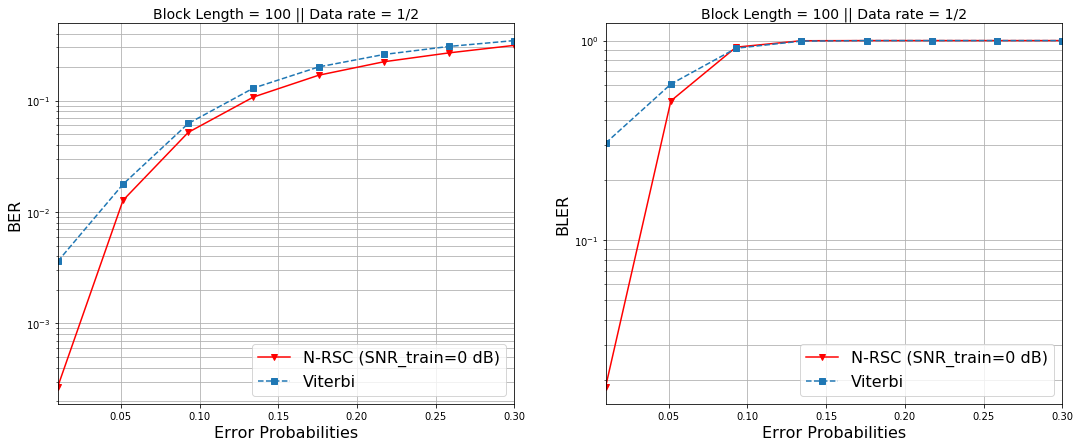

In [10]:
# ###################################
# Plot Bit Error Rate (BER) Curve
# ###################################
plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
plt.title('Block Length = 100 || Data rate = 1/2', fontsize=14)

plt.semilogy(ERROR_PROBS, neuralBERs, '-vr')
plt.semilogy(ERROR_PROBS, viterbiBERs, 's--')
plt.legend(['N-RSC (SNR_train=0 dB)', 'Viterbi'], fontsize=16)
plt.xlabel('Error Probabilities', fontsize=16)
plt.xlim(xmin=ERROR_PROBS[0], xmax=ERROR_PROBS[-1])  # this line
plt.ylabel('BER', fontsize=16)
plt.grid(True, which='both')
plt.savefig('result_ber_block_length_1000_snr0.png')

# ###################################
# Plot Block Error Rate (BLER) Curve
# ###################################
plt.subplot(1, 2, 2)
plt.title('Block Length = 100 || Data rate = 1/2', fontsize=14)

plt.semilogy(ERROR_PROBS, neuralBLERs, '-vr')
plt.semilogy(ERROR_PROBS, viterbiBLERs, 's--')
plt.ylabel('BLER', fontsize=16)
plt.xlabel('Error Probabilities', fontsize=16)
plt.legend(['N-RSC (SNR_train=0 dB)', 'Viterbi'], fontsize=16)

plt.xlim(xmin=ERROR_PROBS[0], xmax=ERROR_PROBS[-1])  # this line
plt.grid(True, which='both')
plt.savefig('result_bler_block_length_1000_snr0.png')

##  Benchmark on K = 1000

In [ ]:
_, Y_test = create_dataset(NUM_TESTING_DATA, 1000, trellis, snr=0.0, seed=1111)

In [ ]:
viterbiBERs, viterbiBLERs = [], []
neuralBERs, neuralBLERs = [], []

pool = mp.Pool(processes=mp.cpu_count())
labels = np.reshape(Y_test, (-1, BLOCK_LEN)).astype(int)
try: 
    ERROR_PROBS  = np.linspace(0.01, 0.3, 8)
    for error_prob in ERROR_PROBS:
        print('[Prob]={:.2f}'.format(error_prob))
        
        # Generates new noisy signals
        result = pool.starmap(
            func=generate_noisy_input,  
            iterable=[(msg_bits, trellis, error_prob) for msg_bits in labels])
        
        X, Y =  zip(*result)
        
        # #################################################################
        # BENCHMARK NEURAL DECODER 
        # #################################################################
        nn_start = time.time()
        hamm_dists = benchmark_neural_decoder(X, Y)
        
        nn_ber = sum(hamm_dists) / np.product(np.shape(Y))
        nn_bler = np.count_nonzero(hamm_dists) / len(Y)

        neuralBERs.append(nn_ber)
        neuralBLERs.append(nn_bler)            
        print('\tNeural Decoder:  [BER]={:5.7f} [BLER]={:5.3f} -- {:3.3f}s'.format(
            nn_ber, nn_bler, time.time() - nn_start)) 

        # #################################################################
        # BENCHMARK VITERBI DECODER 
        # #################################################################
        vi_start = time.time()
        hamm_dists = pool.starmap(benchmark_viterbi, [(y, x, sigma) for x, y in zip(X, Y)])
        
        ber = sum(hamm_dists) / np.product(np.shape(Y))
        bler = np.count_nonzero(hamm_dists) / len(Y)
        
        viterbiBERs.append(ber)
        viterbiBLERs.append(bler)
        print('\tViterbi Decoder: [BER]={:5.7f} [BLER]={:5.3f} -- {:3.3f}s'.format(
              ber, bler, time.time() - vi_start))
        
except Exception as e:
    print(e)
finally:
    pool.close()

In [ ]:
# ###################################
# Plot Bit Error Rate (BER) Curve
# ###################################
plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
plt.title('Block Length = 100 || Data rate = 1/2', fontsize=14)

plt.semilogy(ERROR_PROBS, neuralBERs, '-vr')
plt.semilogy(ERROR_PROBS, viterbiBERs, 's--')
plt.legend(['N-RSC (SNR_train=0 dB)', 'Viterbi'], fontsize=16)
plt.xlabel('Error Probabilities', fontsize=16)
plt.xlim(xmin=ERROR_PROBS[0], xmax=ERROR_PROBS[-1])  # this line
plt.ylabel('BER', fontsize=16)
plt.grid(True, which='both')
plt.savefig('result_ber_block_length_1000_snr0.png')

# ###################################
# Plot Block Error Rate (BLER) Curve
# ###################################
plt.subplot(1, 2, 2)
plt.title('Block Length = 100 || Data rate = 1/2', fontsize=14)

plt.semilogy(ERROR_PROBS, neuralBLERs, '-vr')
plt.semilogy(ERROR_PROBS, viterbiBLERs, 's--')
plt.ylabel('BLER', fontsize=16)
plt.xlabel('Error Probabilities', fontsize=16)
plt.legend(['N-RSC (SNR_train=0 dB)', 'Viterbi'], fontsize=16)

plt.xlim(xmin=ERROR_PROBS[0], xmax=ERROR_PROBS[-1])  # this line
plt.grid(True, which='both')
plt.savefig('result_bler_block_length_1000_snr0.png')